<a href="https://colab.research.google.com/github/phantom-balance/HybridEnergy/blob/master/Copy_of_main_electricity_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NEW

In [1]:
from IPython.display import clear_output
!pip install pymoo
clear_output()

#OLD

In [ ]:
!pip install pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 kB 827.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.8 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=431681dad7272cafd05f1d4a6488355f288e633ea20fa29bc0199771c8939314
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme


In [ ]:
# from itertools import count
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymoo
from pymoo.optimize import minimize
from pymoo.core.problem import Problem

df = pd.read_csv('HOURLY_DATA.csv')
print(df.max(axis=0)['deficit_energy'])
print(df.min(axis=0)['deficit_energy'])
# print(df.head(10))
# df = df[0:5000]
df['deficit_energy']=df['deficit_energy']*1000
df['deficit_energy'] = df['deficit_energy'].apply(lambda x: round(x, 6))
df['ghi']=df['ghi']/1000

# print(df.head(10))

N = 20 # project_life
i = 0.06 # interest_rate
solar_cost_unit = 727 #
solar_OM = 4
CRF = (i*((1+i)**N))/(((1+i)**N)-1)
d_f = 0.88 #derating_factor
Gt_stc = 1 #kw/m2
ap = -0.0035 #solar mod temp coeff of power(%/oC)
T_cstc = 25 #oC standard temp
NOCT = 45 #oC
n_bat = 0.92 #round trip efficieny

gasifier_cost_unit = 2300
gasifier_OM = 2
gasifier_CUF = 0.55 # capacity utilization factor

battery_cost_unit = 200
battery_OM = 0.77


def cost_pv(solar):
  solar_cost = solar*((CRF*solar_cost_unit)+solar_OM)
  # print(solar_cost)
  return solar_cost

def cost_gasifier(gasifier):
  gasifier_cost = gasifier*((CRF*gasifier_cost_unit)+gasifier_OM)
  # print(gasifier_cost)
  return gasifier_cost

def cost_battery(battery):
  battery_cost = battery*((CRF*battery_cost_unit)+battery_OM)
  return battery_cost

def LCOE(total_energy_prod, solar, gasifier, battery):
  ASC = cost_pv(solar)+cost_gasifier(gasifier)+cost_battery(battery)
  energy_prod_per_year = total_energy_prod/N
  lcoe = ASC/(energy_prod_per_year)
  return ASC, lcoe

def solar_ene_prod(solar_rate, solar_rad, temp):
  T_cell = temp+Gt_stc*((NOCT-20)/0.8)
  p_op = solar_rate*d_f*(solar_rad/Gt_stc)*(1+ap*(T_cell-T_cstc))
  return p_op

# print(solar_ene_prod(1000, 0.799037304, 1.2))

def gasifier_ene_prod(gasifier_rate):
  return gasifier_rate*gasifier_CUF

def Energy_prod(solar_rate, solar_rad, gasifier_rate, temp):
  solar_energy = solar_ene_prod(solar_rate, solar_rad, temp)
  gasifier_energy = gasifier_ene_prod(gasifier_rate)
  energy_prod = solar_energy + gasifier_energy
  return energy_prod
def Energy_prod_(energy_def, battery_E, battery_max, solar_rate, solar_rad, gasifier_rate, temp):
  # print(energy_def)
  energy_def=-energy_def
  # print(energy_def)
  energy_prod = 0
  solar_energy = 0
  gasifier_energy = 0
  # print(battery_E)
  battery_E_up = battery_E
  battery_supply = 0

  solar_energy = solar_ene_prod(solar_rate, solar_rad, temp)
  if energy_def>0:
    # print("1",energy_def)


    if solar_energy-energy_def<0:
      # run battery and gasifier
      #req_energy needs to be addressed by gasifier and battery
      req_energy = energy_def-solar_energy

      if battery_E>battery_max*0.3:
        # print("0")
        if req_energy<=(battery_E-battery_max*0.3):


          # req_energy met by only battery
          battery_supply = req_energy
          # print("1",battery_supply)

          battery_E_up = battery_E-req_energy

          # print("1", battery_E_up)


        else:
          # print("2")


          # req_energy met by battery and gasifier
          gasifier_E_req = req_energy-(battery_E-battery_max*0.3)

          battery_supply = battery_E-0.3*battery_max
          # print("2",battery_supply)
          battery_E_up = 0.3*battery_max
          gasifier_energy_op = gasifier_ene_prod(gasifier_rate)

          if gasifier_energy_op>gasifier_E_req:
            gasifier_energy = gasifier_E_req #remaining gasifier energy could charge the battery

          else:
             print("# THE CURRENT SYSTEM RATING ISN'T ABLE TO FULLFIL THE DEFECIT, NEW HYBRID COMBINATION REQUIRED")  #
          # print("2", battery_E_up)

          # gasifier_energy = gasifier_ene_prod(gasifier_rate)#'change this to battery supply'
          # gasifier_energy = gasifier_E_req

      else:
        #req_energy met only by gasifier
        gasifier_energy_op = gasifier_ene_prod(gasifier_rate)

        if req_energy<gasifier_energy_op:
          excess_energy = gasifier_energy_op-req_energy
          gasifier_energy = req_energy

          "MAYBE ADD BATTERY CHARGING HERE LATER"
        else:
          print("THE CURRENT SYSTEM RATING ISN'T ABLE TO FULLFIL THE DEFECIT, NEW HYBRID COMBINATION REQUIRED")
          pass
          "THE CURRENT SYSTEM RATING ISN'T ABLE TO FULLFIL THE DEFECIT, NEW HYBRID COMBINATION REQUIRED"



    else:
      # solar supplies total demand and remaining charge is used to charge battery
      #battery_charge(soc min, soc max)
      Pch_t = solar_energy-energy_def
      Ech_t = Pch_t*n_bat

      if Ech_t<=battery_max-battery_E:

        battery_E_up = battery_E+Ech_t
        # print("3", battery_E_up)
      else:

        battery_E_up = battery_max
        # print("4", battery_E_up)
        E_dump = Ech_t - (battery_max-battery_E)
        Ech_t = battery_max-battery_E

    energy_prod = solar_energy + gasifier_energy

  else :
    gasifier_energy=0
    battery_supply=0
    # print("3",battery_supply)
    energy_prod=solar_energy+gasifier_energy #solar energy already calculated outside loop

    surplus_ene = abs(energy_def)#make hydrogen from this

    Pch_t = solar_energy
    Ech_t = Pch_t*n_bat
    # battery_E_up = battery_max

    if Ech_t<=battery_max-battery_E:
      battery_E_up = battery_E+Ech_t

    else:

      battery_E_up = battery_max
      E_dump = Ech_t - (battery_max-battery_E)
      Ech_t = battery_max-battery_E

    #battery charge
    #solar, energy_prod
    #make hydrogen
  # print("4",battery_supply)

  return energy_prod, battery_supply, battery_E_up, solar_energy, gasifier_energy





2140.059371373537
-1302.30110208317


In [ ]:
class ProblemWrapper(Problem):
  def _evaluate(self, designs, out, *args, **kwargs):
    res = []
    res1 =[]
    for design in designs:
      solar, gasifier, battery = design
      solar = int(solar)
      gasifier = int(gasifier)
      battery = int(battery)
      # battery = 1000

      count = 0
      Energy_prod_N = 0 #total energy throughout the project life produced
      battery_E = battery

      for i in range(len(df)):
        # Energy_produced = Energy_prod(solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
        n_battery_E = battery_E
        Energy_produced,battery_supply, battery_E, _, _ = Energy_prod_(energy_def=df['deficit_energy'][i] ,battery_E=battery_E ,battery_max=battery, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])


        Energy_prod_N += Energy_produced

        energy_tot = df['deficit_energy'][i]+Energy_produced+battery_supply
        energy_tot = round(energy_tot, 4)



        if energy_tot<0 and count!=1:
          count = 1
          # print(i)
          # print(Energy_produced)
          # print(Energy_produced+battery_supply)
          # print(battery_E/battery)
          # print(solar, gasifier, battery)
          # print(energy_tot)
          # print(battery_supply)
          # print(df['deficit_energy'][i])


      asc, lcoe = LCOE(Energy_prod_N, solar, gasifier, battery)
      res.append(lcoe)
      res1.append(count)
    out['F']=np.array(res)
    out['H']=np.array(res1)

problem = ProblemWrapper(n_var=3, n_obj=1, n_eq_constr=1, xl=[54061102, 2367822, 540611*6], xu=[54062102, 3073500, 540621*6])

In [ ]:
# from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.ga import GA

# algorithm = NSGA2(pop_size=100)
algorithm = GA(pop_size=10, eliminate_duplicate=True)

In [ ]:
stop_criteria = ('n_gen', 100)

In [ ]:
%%time
results = minimize(problem=problem,
                   algorithm=algorithm,
                   termination=stop_criteria,
                   seed=42,
                   save_history=True)

CPU times: user 1h 49min 53s, sys: 18.5 s, total: 1h 50min 11s
Wall time: 1h 51min 35s


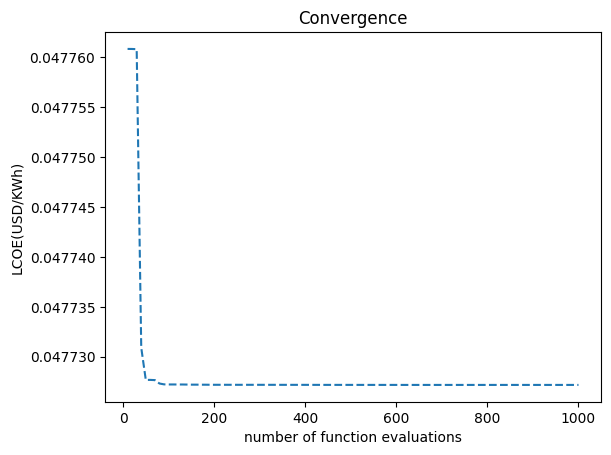

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n_evals = np.array([e.evaluator.n_eval for e in results.history])
opt = np.array([e.opt[0].F for e in results.history])

plt.title("Convergence")
plt.plot(n_evals, opt, "--")
plt.xlabel("number of function evaluations")
plt.ylabel("LCOE(USD/KWh)")
# plt.yscale("log")
plt.show()

In [ ]:
# print(df.max(axis=0)['deficit_energy'])
# print(df.min(axis=0)['deficit_energy'])
# print(df.idxmin())

-155077.295675
-614713.304994
time                0
ghi                 0
air_temperature    79
month               0
hour                0
deficit_energy     18
dtype: int64


In [ ]:
results.F

array([0.04772718])

In [ ]:
results.X

array([54062101.96861364,  2367822.00013084,  3243666.57315318])

In [ ]:
results.X

array([54061961.31094974,  2367829.06025074,  3243724.43503727])

In [ ]:
solar, gasifier, battery  = 4999377.04458996, 2154796.49363467, 4002532.14102314
solar = int(solar)
gasifier = int(gasifier)
battery = int(battery)
# battery = 1000

count = 0
Energy_prod_N = 0 #total energy throughout the project life produced
battery_E = battery

# for i in range(len(df)):
for i in range(8000):
  # Energy_produced = Energy_prod(solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
  n_battery_E = battery_E
  Energy_produced,battery_supply, battery_E, _, _ = Energy_prod_(energy_def=df['deficit_energy'][i] ,battery_E=battery_E ,battery_max=battery, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])


  Energy_prod_N += Energy_produced

  energy_tot = df['deficit_energy'][i]+Energy_produced+battery_supply
  energy_tot = round(energy_tot, 4)



  if energy_tot<0 and count!=1:
    count = 1
    print(i)
    print(Energy_produced)
    print(Energy_produced+battery_supply)
    print(battery_E/battery)
    print(solar, gasifier, battery)
    print(energy_tot)
    print(battery_supply)
    print(df['deficit_energy'][i])


asc, lcoe = LCOE(Energy_prod_N, solar, gasifier, battery)
print(asc, lcoe)
print(count)

0

In [ ]:
# solar, gasifier, battery = results.X

solar, gasifier, battery  = 4999377.04458996, 2154796.49363467, 4002532.14102314

solar_array = []
gasifier_array = []
battery_array = []
deficit_array = []

total_supply = []

count = 0
Energy_prod_N = 0
battery_E = battery
for i in range(len(df)):


  # Energy_produced = Energy_prod(solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
  Energy_produced, battery_supply, battery_E, solar_ene, gasifier_ene = Energy_prod_(energy_def=df['deficit_energy'][i] ,battery_E=battery_E ,battery_max=battery, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
  Energy_prod_N += Energy_produced
  deficit_array.append(df['deficit_energy'][i])
  solar_array.append(solar_ene)
  gasifier_array.append(gasifier_ene)
  battery_array.append(battery_E)
  total_supply.append(battery_supply+gasifier_ene+solar_ene)

asc, lcoe = LCOE(Energy_prod_N, solar, gasifier, battery)
print(asc, lcoe)

846146677.582203 0.10245455195913505


In [ ]:
np.argmax(np.array(solar_array))

5868

[0, 0, 0, 0, 0, 146367.35987260047, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 191931.42288542422, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 64157.92824775737, 281617.2441078326, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 48944.72748161852, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 39139.07423145074, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

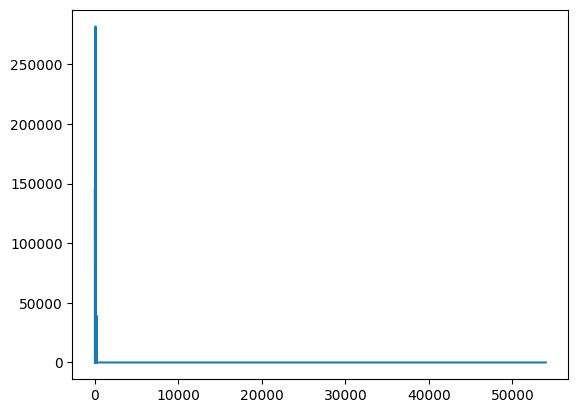

In [ ]:
j = 126000
i = 180000
plt.plot(gasifier_array[j:i], label = 'battery')
print(gasifier_array[j:i])

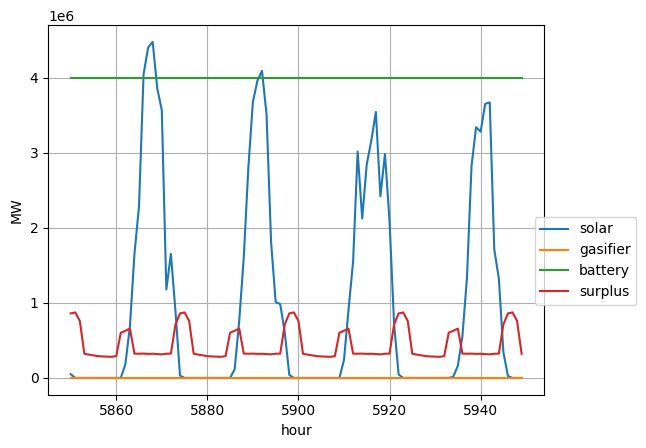

In [ ]:
# j=2850
# i=2950
x = np.arange(j,i)
j = 5850
i = 5950
plt.plot(x,solar_array[j:i], label='solar')
plt.plot(x,gasifier_array[j:i], label='gasifier')
plt.plot(x,battery_array[j:i], label = 'battery')
# plt.plot(x,np.add(np.array(battery_array[j:i]),-973117), label = 'battery')
# plt.plot(x,-np.array(deficit_array[j:i]), label = 'deficit')
plt.plot(x,np.array(deficit_array[j:i]), label = 'surplus')

plt.xlabel("hour")
plt.ylabel("MW")
# plt.plot(x,total_supply[j:i], label = 'total')
plt.grid()
plt.legend(loc='upper right',bbox_to_anchor=(1.2,0.5))

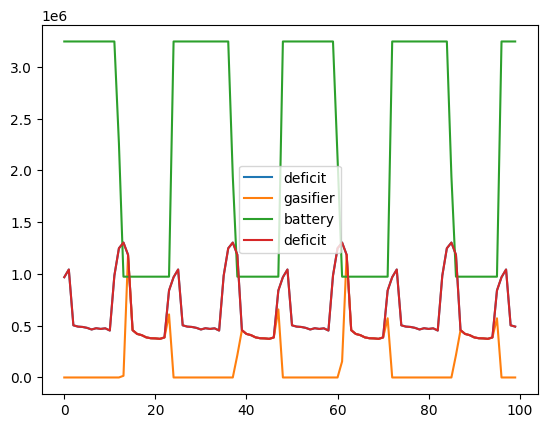

In [ ]:
plt.plot(-np.array(deficit_array[3150:3250]), label = 'deficit')
# plt.plot(solar_array[3150:3250], label='solar')
plt.plot(gasifier_array[3150:3250], label='gasifier')
plt.plot(battery_array[3150:3250], label = 'battery')
plt.plot(-np.array(deficit_array[3150:3250]), label = 'deficit')
plt.legend()

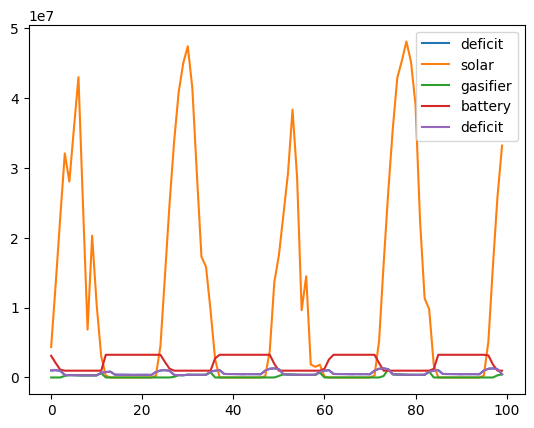

In [ ]:
plt.plot(-np.array(deficit_array[2850:2950]), label = 'deficit')
plt.plot(solar_array[3150:3250], label='solar')
plt.plot(gasifier_array[2850:2950], label='gasifier')
plt.plot(battery_array[2850:2950], label = 'battery')
plt.plot(-np.array(deficit_array[2850:2950]), label = 'deficit')
plt.legend()

In [ ]:
class ProblemWrapper(Problem):
  def _evaluate(self, designs, out, *args, **kwargs):
    res = []
    res1 =[]
    for design in designs:
      solar, gasifier, battery = design

      count = 0
      Energy_prod_N = 0
      battery_E = battery

      for i in range(len(df)):
        n_battery_E = battery_E
        Energy_produced,battery_supply, battery_E, _, _ = Energy_prod_(energy_def=df['deficit_energy'][i] ,battery_E=battery_E ,battery_max=battery, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])

        Energy_prod_N += Energy_produced

        energy_tot = df['deficit_energy'][i]+Energy_produced+battery_supply


        if round(energy_tot, 4)<0 and count!=1:
          count = 1
          print(i)
          print(Energy_produced)
          print(Energy_produced+battery_supply)
          print(battery_E/battery)
          print(df['deficit_energy'][i])
          print(solar, gasifier, battery)
          print(energy_tot)

      asc, lcoe = LCOE(Energy_prod_N, solar, gasifier, battery)
      res.append(lcoe)
      res1.append(count)
    out['F']=np.array(res)
    out['H']=np.array(res1)

In [ ]:
a = -1.2732925824820995e-11
print(round(a, 4))
round(a,2)==0

-0.0


True

In [ ]:
%%time
problem = ProblemWrapper(n_var=3, n_obj=1, n_eq_constr=1, xl=[2000000, 23672, 2000000*2], xu=[5000000,2367822, 5000000])
algorithm = GA(pop_size=1000, eliminate_duplicate=True)
stop_criteria = ('n_gen', 10)
results = minimize(problem=problem,
                   algorithm=algorithm,
                   termination=stop_criteria,
                   seed=42,
                   save_history=True)

In [ ]:
print(results.F)
results.X

[3.33255899]


array([4665157.86694422, 2165420.88362467, 4549535.99287521])

In [ ]:
print(results.F)
results.X

[3.14038955]


array([4999377.04458996, 2154796.49363467, 4002532.14102314])

In [ ]:
solar, gasifier, battery = results.X


solar_array = []
gasifier_array = []
battery_array = []
deficit_array = []

total_supply = []

count = 0
Energy_prod_N = 0
battery_E = battery
for i in range(len(df)):
  # Energy_produced = Energy_prod(solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
  Energy_produced, battery_supply, battery_E, solar_ene, gasifier_ene = Energy_prod_(energy_def=df['deficit_energy'][i] ,battery_E=battery_E ,battery_max=battery, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
  Energy_prod_N += Energy_produced
  deficit_array.append(df['deficit_energy'][i])
  solar_array.append(solar_ene)
  gasifier_array.append(gasifier_ene)
  battery_array.append(battery_E)
  total_supply.append(battery_supply+gasifier_ene+solar_ene)

asc, lcoe = LCOE(Energy_prod_N, solar, gasifier, battery)
print(asc, lcoe)

846146677.5822029 3.140389549194661


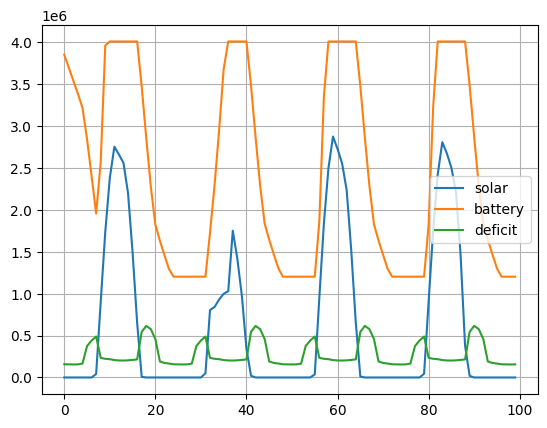

In [ ]:
# plt.plot(np.add(np.array(solar_array[0:100]),1200760), label='solar')
plt.plot(solar_array[0:100], label='solar')

# plt.plot(gasifier_array[0:100], label='gasifier')
plt.plot(battery_array[0:100], label = 'battery')
plt.plot(-np.array(deficit_array[0:100]), label = 'deficit')
# plt.plot(total_supply[0:100], label = 'total')

# plt.plot(total_supply[0:100], label = 'total')
plt.grid()
plt.legend()

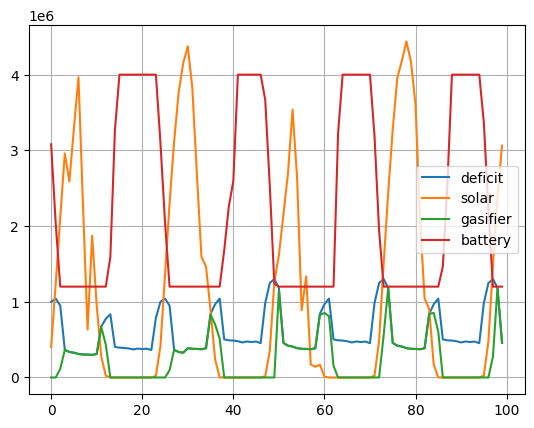

In [ ]:
plt.plot(-np.array(deficit_array[2850:2950]), label = 'deficit')
plt.plot(solar_array[3150:3250], label='solar')
plt.plot(gasifier_array[2850:2950], label='gasifier')
plt.plot(battery_array[2850:2950], label = 'battery')
# plt.plot(-np.array(deficit_array[2850:2950]), label = 'deficit')
plt.grid()
plt.legend()